In [62]:
import numpy as np
import scipy.interpolate as intrplt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pyDOE import *
import time 

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
#from cuml.gaussian_process import GaussianProcessRegressor
#from cuml.gaussian_process.kernels import RBF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2,l1_l2
import tensorflow.keras as keras
import tensorflow as tf




from ipywidgets import interactive
import ipywidgets as widgets 

In [2]:
def f(t,a=0.1,b=-0.13,c=9):
    return np.sqrt(a)*np.exp(-b*t)*np.sin(c*t)+.5*np.cos(2*t)

def plot_with_parameters(a,b,c):
    ts= np.linspace(0,1,100)
    fs= f(ts,a,b,c)

    plt.plot(ts,fs,c='Red',label=f'f(t;{a},{b},{c})')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

def interactive_err(a):
    ts= np.linspace(0,1,100)
    a_s= np.linspace(0,1,10)
    fs_for_as= np.array([f(ts,a=i) for i in a_s]).T
    intrpltr= intrplt.RectBivariateSpline(ts,a_s,fs_for_as,kx=1,ky=1)
    intrpltd_fs= intrpltr(ts,a).reshape(-1)
    true_fs= f(ts,a=a)
    resid_errs= true_fs/intrpltd_fs-1
    plt.plot(ts,resid_errs,label=f'a={a}')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.title('Ratio')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def inter_grid(lhd,a,b):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi) for ai,bi in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b)))

    intrpltd_fs= np.array(intrpltd_fs)

    true_fs= f(ts,a=a,b=b)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.plot(ts,true_fs,label='true f(t)')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()

def intrpltd_grid(lhd,a,b):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi) for ai,bi in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b)))

    return np.array(intrpltd_fs)

def true_grid(a=0.1,b=-0.13,c=9.):
    ts= np.linspace(0,1,100)
    return f(ts,a=a,b=b,c=c)

def n_d_intrpltd(lhd,a,b,c):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi,c=ci) for ai,bi,ci in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b,c)))

    return np.array(intrpltd_fs)

def n_d_inter_grid(lhd,a,b,c):
    ts= np.linspace(0,1,100)
    fs= np.array([f(ts,a=ai,b=bi,c=ci) for ai,bi,ci in lhd]).T
    intrpltd_fs=[]
    for i,t in enumerate(ts):
        intrpltd_fs.append(intrplt.griddata(lhd,fs[i],(a,b,c)))

    intrpltd_fs= np.array(intrpltd_fs)

    true_fs= f(ts,a=a,b=b,c=c)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)')
    ax1.plot(ts,true_fs,label='true f(t)')
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b},c={c}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()


def gpr_intrpltd(gpr,a,b,c):
    ts= np.linspace(0,1,100)
    X_test= np.hstack((ts.reshape((-1,1)),np.vstack([[a,b,c] for _ in range(100)])))
    return(gpr.predict(X_test,return_std=True))

def inter_gpr(gpr,a,b,c):
    ts= np.linspace(0,1,100)
    X_test= np.hstack((ts.reshape((-1,1)),np.vstack([[a,b,c] for _ in range(100)])))
    intrpltd_fs, pred_errs= gpr.predict(X_test,return_std=True)

    true_fs= f(ts,a=a,b=b,c=c)
    resid_errs= true_fs/intrpltd_fs-1

    fig= plt.figure(figsize=(14,8))
    ax1= fig.add_subplot(121)
    ax1.plot(ts,intrpltd_fs, label='interpolated f(t)',ls='--')
    ax1.fill_between(ts,intrpltd_fs-1.96*pred_errs,intrpltd_fs+1.96*pred_errs,alpha=0.5,label='0.95 certainty')
    ax1.plot(ts,true_fs,label='true f(t)',alpha=0.3)
    ax1.set(xlabel='t',ylabel='f(t)')
    ax1.grid(True)
    ax1.legend(loc='lower left')
    ax2= fig.add_subplot(122)
    ax2.plot(ts,resid_errs,label=f'a={a},b={b},c={c}')
    ax2.set(xlabel='t',ylabel='f(t)',title='Ratio')
    ax2.grid(True)
    ax2.legend(loc='lower left')
    plt.show()

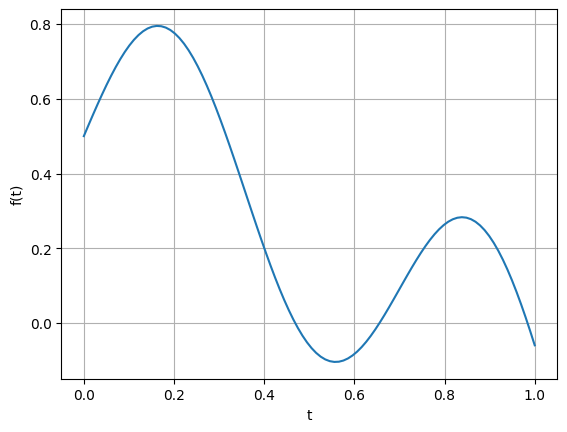

In [8]:
ts= np.linspace(0,1,100)
fs= f(ts)

plt.plot(ts,fs)
plt.ylabel('f(t)')
plt.xlabel('t')
plt.grid(True)
plt.show()

In [9]:
interactive_plot= interactive(
    plot_with_parameters,
    a=widgets.FloatSlider(min=0.,max=1.,step=0.01,value=0.1),
    b=widgets.FloatSlider(min=-0.5,max=.5,step=0.01,value=-0.13),
    c=widgets.FloatSlider(min=5,max=10,step=0.1,value=9)
)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.1, description='a', max=1.0, step=0.01), FloatSlider(value=-0.13, de…

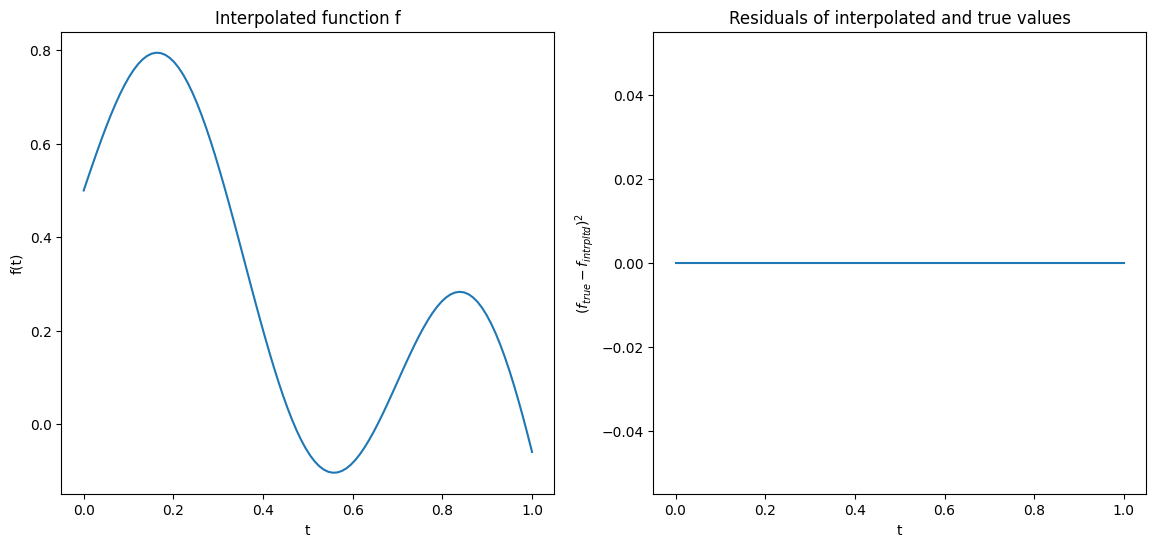

In [10]:
#Q1
#Using the original grid for interpolation

ts= np.linspace(0,1,100)
fs= f(ts)

intrpltr= intrplt.interp1d(ts,fs,kind='linear')

finer_ts= np.linspace(0,1,100)
intrpltd_fs= intrpltr(finer_ts)

true_fs= f(finer_ts)

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(finer_ts,intrpltd_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(finer_ts,(true_fs/intrpltd_fs-1))
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$(f_{true}-f_{intrpltd})^2$", xlabel='t')
plt.show()

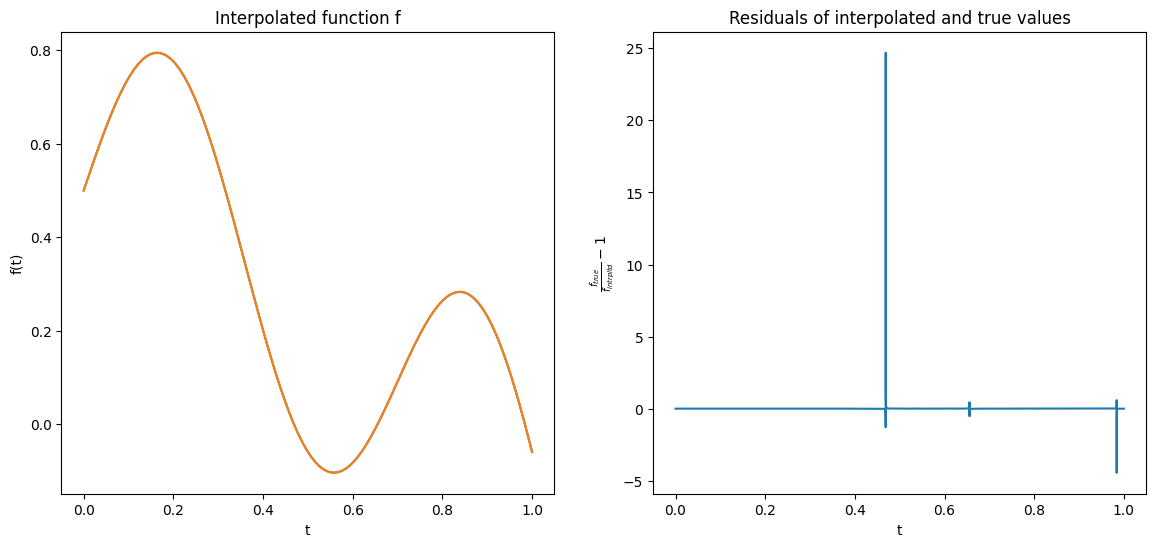

In [11]:
#Q2 and 3
#Fix all parameters except t and interpolate on a finer grid than our initial ts

ts= np.linspace(0,1,100)
fs= f(ts)

intrpltr= intrplt.interp1d(ts,fs,kind='linear')

finer_ts= np.linspace(0,1,10000)
intrpltd_fs= intrpltr(finer_ts)

true_fs= f(finer_ts)
resid_errs= true_fs/intrpltd_fs -1

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(finer_ts,intrpltd_fs)
ax1.plot(finer_ts,true_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(finer_ts,resid_errs)
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$\frac{f_{true}}{f_{intrpltd}}-1$", xlabel='t')
plt.show()

In [12]:
print(f"Values of f that result in a higher relative error:\
      \n{np.column_stack((finer_ts[np.argsort(resid_errs)[:10]],true_fs[np.argsort(resid_errs)[:10]]))}")

print("Clearly relative error is highest near the roots of the function")

Values of f that result in a higher relative error:      
[[ 9.83998400e-01  1.48722212e-04]
 [ 4.68746875e-01 -6.23341709e-05]
 [ 4.68646865e-01  1.65592117e-04]
 [ 6.55765577e-01  3.77820621e-05]
 [ 9.84098410e-01 -2.13607737e-04]
 [ 4.68546855e-01  3.93742442e-04]
 [ 4.68446845e-01  6.22116674e-04]
 [ 9.84198420e-01 -5.76093605e-04]
 [ 4.68346835e-01  8.50714685e-04]
 [ 4.68246825e-01  1.07953635e-03]]
Clearly relative error is highest near the roots of the function


In [13]:
#Q5

ts= np.linspace(0,1,100)
a_s= np.linspace(0,1,10)
#Making an array of the time coordinates and the varied a coordinates
fs_for_as= np.array([f(ts,a=a) for a in a_s]).T

f_a_df= pd.DataFrame(fs_for_as)#Indexing columns Python style
f_a_df.columns= np.round(np.linspace(0,1,10),2)
f_a_df.insert(0,'t',ts)


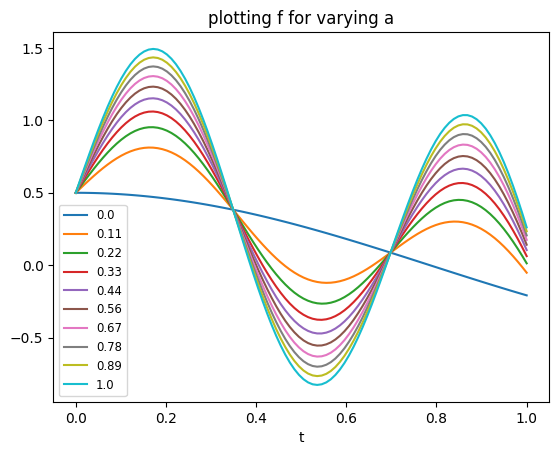

In [14]:
fig,ax= plt.subplots()
for col in f_a_df.columns[1:]:
    f_a_df.plot('t',col,ax=ax)

plt.title('plotting f for varying a')
plt.legend(loc='lower left',fontsize='small')
plt.show()

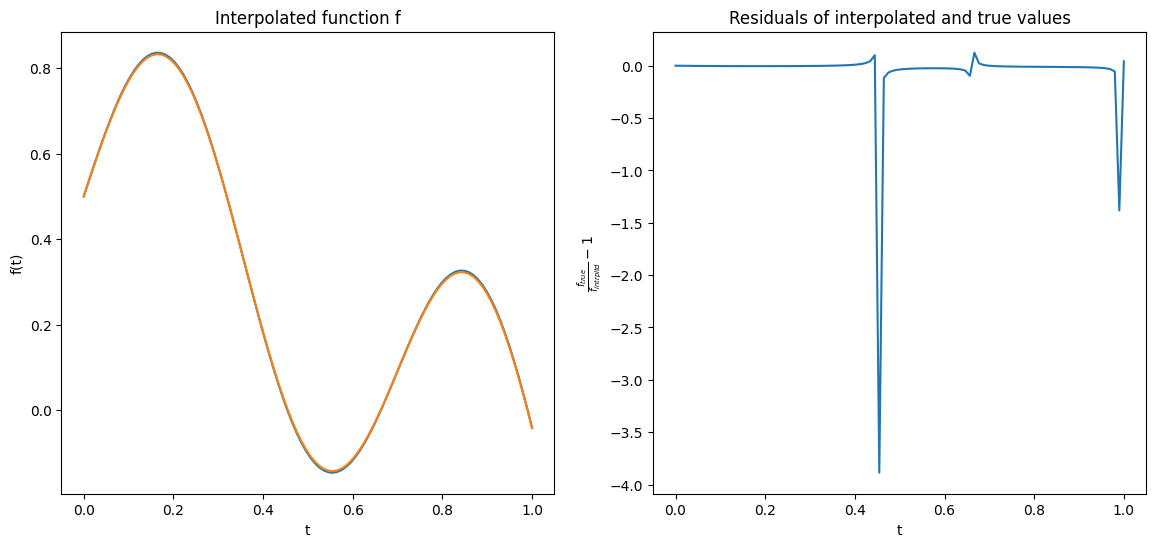

In [15]:
#Q6 interpolating over a grid
intrpltr= intrplt.RectBivariateSpline(ts,a_s,fs_for_as)
intrpltd_fs= intrpltr(ts,0.125).reshape(-1)
true_fs= f(ts,a=0.125)

resid_err= true_fs/intrpltd_fs-1

fig= plt.figure(figsize=(14,6))

ax1= fig.add_subplot(121)
ax1.plot(ts,intrpltd_fs)
ax1.plot(ts,true_fs)
ax1.set(title='Interpolated function f',ylabel='f(t)',xlabel='t')
ax2= fig.add_subplot(122)
ax2.plot(ts,resid_err)
ax2.set(title='Residuals of interpolated and true values',ylabel=r"$\frac{f_{true}}{f_{intrpltd}}-1$", xlabel='t')
plt.show()


In [16]:
#Question 7
inter_err_plot= interactive(
    interactive_err,
    a= widgets.FloatSlider(min=0,max=1,step=0.005,value=0.125)
)
display(inter_err_plot)

interactive(children=(FloatSlider(value=0.125, description='a', max=1.0, step=0.005), Output()), _dom_classes=…

### Q8
The ratio of error gets smaller as we get 'a' closer to a value that we have calculated analytically, this makes sense as we expect to get the exact analytical value more or less at those points

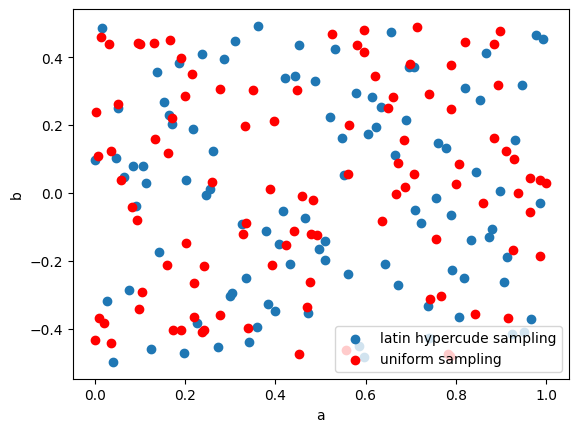

In [17]:
#Q9 and 10
lhd= lhs(2,samples=100)
lhd[:,1]-=0.5

a_s= np.random.uniform(0,1,100)
bs= np.random.uniform(-0.5,0.5,100)

plt.scatter(lhd[:,0],lhd[:,1],label='latin hypercude sampling')
plt.scatter(a_s,bs,c='Red',label='uniform sampling')
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.show()

LHS points are guarunteed to have only one sample at each grid point axis, while uniformly sapled points aren't spread as evenly.

To distinguish between the two, an easy check would be to see if consecutive points are equidistant from each other in each axis 

In [18]:
np.sort(lhd[:,0].round(3))

array([0.002, 0.016, 0.027, 0.04 , 0.047, 0.052, 0.066, 0.076, 0.086,
       0.092, 0.106, 0.113, 0.124, 0.137, 0.143, 0.154, 0.165, 0.172,
       0.186, 0.199, 0.203, 0.218, 0.228, 0.238, 0.246, 0.255, 0.263,
       0.273, 0.286, 0.299, 0.304, 0.31 , 0.327, 0.335, 0.343, 0.359,
       0.362, 0.379, 0.384, 0.4  , 0.409, 0.418, 0.422, 0.432, 0.443,
       0.453, 0.467, 0.472, 0.488, 0.498, 0.509, 0.51 , 0.521, 0.532,
       0.548, 0.552, 0.561, 0.58 , 0.586, 0.595, 0.605, 0.615, 0.624,
       0.634, 0.643, 0.656, 0.665, 0.673, 0.689, 0.695, 0.707, 0.71 ,
       0.723, 0.739, 0.74 , 0.755, 0.76 , 0.779, 0.788, 0.79 , 0.806,
       0.818, 0.82 , 0.833, 0.844, 0.853, 0.867, 0.873, 0.881, 0.897,
       0.907, 0.912, 0.925, 0.932, 0.946, 0.951, 0.967, 0.977, 0.986,
       0.992])

In [19]:
np.sort(a_s).round(3)

array([0.002, 0.004, 0.007, 0.011, 0.015, 0.02 , 0.031, 0.036, 0.037,
       0.051, 0.06 , 0.082, 0.094, 0.097, 0.097, 0.099, 0.105, 0.132,
       0.135, 0.159, 0.162, 0.166, 0.171, 0.174, 0.191, 0.191, 0.2  ,
       0.201, 0.216, 0.219, 0.221, 0.239, 0.241, 0.242, 0.259, 0.277,
       0.277, 0.328, 0.333, 0.336, 0.339, 0.352, 0.389, 0.392, 0.398,
       0.423, 0.441, 0.449, 0.453, 0.46 , 0.47 , 0.478, 0.478, 0.482,
       0.493, 0.525, 0.557, 0.561, 0.564, 0.581, 0.596, 0.597, 0.621,
       0.637, 0.649, 0.661, 0.667, 0.673, 0.684, 0.686, 0.699, 0.708,
       0.713, 0.74 , 0.743, 0.755, 0.768, 0.783, 0.786, 0.789, 0.79 ,
       0.8  , 0.807, 0.82 , 0.842, 0.859, 0.885, 0.885, 0.893, 0.897,
       0.91 , 0.915, 0.926, 0.928, 0.937, 0.963, 0.964, 0.986, 0.987,
       1.   ])

In [20]:
#Q11 and 12
inter_grid_plot= interactive(
    inter_grid,
    lhd= widgets.fixed(lhd),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value=lhd[0,0]),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=lhd[0,1])
)

display(inter_grid_plot)

interactive(children=(FloatSlider(value=0.18618190930836845, description='a', max=1.0, step=1e-10), FloatSlide…

The error in interpolated data goes down as we get closer to grid points where the value was calculated analytically which is to be expected.

In [21]:
start_time= time.time()
for a in np.linspace(0,1,4):
    for b in np.linspace(-0.5,0.5,3):
        intrpltd_grid(lhd,a,b)
end_time= time.time()

print(f"Time taken for 12 interpolation calls: {end_time-start_time} seconds")

Time taken for 12 interpolation calls: 6.5816733837127686 seconds


In [22]:
start_time= time.time()
for a in np.linspace(0,1,10):
    for b in np.linspace(-0.5,0.5,10):
        true_grid(a,b)
end_time= time.time()

print(f"Time taken for 100 true calls: {end_time-start_time} seconds")

Time taken for 100 true calls: 0.00212860107421875 seconds


In [23]:
a= np.linspace(0,1,10)
b= np.linspace(-0.5,0.5,10)

A,B= np.meshgrid(a,b)

start_time= time.time()
intrpltd_grid(lhd,A,B)
end_time= time.time()

print(f"Time taken for 100 interpolation calls: {end_time-start_time} seconds")

Time taken for 100 interpolation calls: 0.5314126014709473 seconds


In [26]:
#Q14
lhd= lhs(3,samples=100)
lhd[:,1]-=0.5
lhd[:,2]=5*lhd[:,2]+5

In [25]:
n_d_inter_plot= interactive(
    n_d_inter_grid,
    lhd= widgets.fixed(lhd),
    a= widgets.FloatSlider(min=0,max=1,step=1e-10,value= lhd[0,0]),
    b= widgets.FloatSlider(min=-0.5,max=0.5,step=1e-10,value=lhd[0,1]),
    c= widgets.FloatSlider(min=5,max=10,step=1e-10,value=lhd[0,2])
)

display(n_d_inter_plot)

interactive(children=(FloatSlider(value=0.039921780719676406, description='a', max=1.0, step=1e-10), FloatSlid…

In [26]:
start_time= time.time()
for a in np.linspace(0,1,3):
    for b in np.linspace(-0.5,0.5,2):
        for c in np.linspace(5,10,2):
            n_d_intrpltd(lhd,a,b,c)
end_time= time.time()

print(f"Time taken for 12 interpolation calls: {end_time-start_time} seconds")

Time taken for 12 interpolation calls: 15.823386430740356 seconds


In [27]:
a= np.linspace(0,1,10)
b= np.linspace(-0.5,0.5,10)
c= np.linspace(5,10,10)

A,B,C= np.meshgrid(a,b,c)

start_time= time.time()
n_d_intrpltd(lhd,A,B,C)
end_time= time.time()

print(f"Time taken for 1000 interpolations made with one call: {end_time-start_time} seconds")

Time taken for 1000 interpolations made with one call: 1.4153518676757812 seconds


In [28]:
start_time= time.time()
for a in np.linspace(0,1,10):
    for b in np.linspace(-0.5,0.5,10):
        for c in np.linspace(5,10,10):
            true_grid(a,b,c)
end_time= time.time()

print(f"Time taken for 1000 true calls: {end_time-start_time} seconds")

Time taken for 1000 true calls: 0.024399280548095703 seconds


In [170]:
ts= np.linspace(0,1,100)
X= lhs(3,samples=1000)
X[:,1]-=0.5
X[:,2]= 5*X[:,2]+5
#X=lhd
Y= np.array([f(ts,a,b,c) for a,b,c in X])
X[:,1]+=0.5
X[:,2]= (X[:,2]-5)/5


X_test= lhs(3,samples=100000)
X_test[:,1]-=0.5
X_test[:,2]= 5*X_test[:,2]+5
Y_test= np.array([f(ts,a,b,c) for a,b,c in X_test])
X_test[:,1]+=0.5
X_test[:,2]= (X_test[:,2]-5)/5


model= Sequential()
model.add(Dense(16,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(64,activation='elu'))
#model.add(Dropout(0.1))
model.add(Dense(100))

model.compile(loss=MeanSquaredError,optimizer=Adam(learning_rate=0.01))

history= model.fit(X,Y,epochs=40,verbose=1)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2839   
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0479
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0041
Epoch 10/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036
Epoch 11/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026
Epoch 12/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 
Epoch 13/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023  
Epoch 14/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 15/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018
Epoch 16/40


In [171]:
test= np.array([0.1,-0.13+0.5,(9-5)/5]).reshape(-1,3)
f_test= model.predict(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


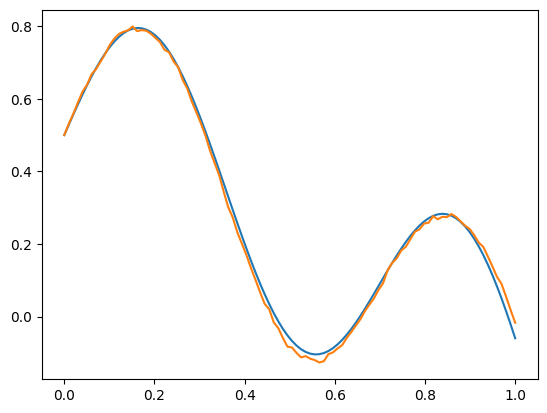

In [172]:
true_fs= f(ts)

plt.plot(ts,true_fs)
plt.plot(ts,f_test[0])
plt.show()

In [29]:
#Q15
#Making a feature set for for scikit learn
ts= np.linspace(0,1,100)
lhd= lhs(3,samples=100)
X= np.hstack((np.vstack([ts for _ in range(100)]).reshape((-1,1)),np.repeat(lhd,100,axis=0)))
Y= np.array([f(t,a,b,c) for t,a,b,c in X])


kernel= 1.*RBF(1.)
gpr= GaussianProcessRegressor(kernel=kernel)
gpr.fit(X,Y)


KeyboardInterrupt: 